# Brain Tumor Detection CNN Training Process
This notebook demonstrates step-by-step how to train a Convolutional Neural Network (CNN) for brain tumor detection using MRI images.

Ten notatnik pokazuje krok po kroku, jak trenować konwolucyjną sieć neuronową (CNN) do wykrywania guzów mózgu przy użyciu obrazów MRI.

In [13]:
# Import necessary libraries / Importowanie niezbędnych bibliotek
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Dropout, Flatten, Dense
from keras._tf_keras.keras.utils import normalize, to_categorical

## Load and Preprocess Data / Wczytywanie i przetwarzanie danych

We load images from two directories: 'datasets/no' for images without tumor (label 0) and 'datasets/yes' for images with tumor (label 1).

Wczytujemy obrazy z dwóch katalogów: 'datasets/no' dla obrazów bez guza (etykieta 0) oraz 'datasets/yes' dla obrazów z guzem (etykieta 1).


In [14]:
# Define image directory and input size / Definicja katalogu z obrazami i rozmiaru wejściowego
image_directory = 'datasets/'
INPUT_SIZE = 64

# Lists to store data and labels / Listy do przechowywania danych i etykiet
dataset = []
labels = []

In [15]:
# Load images without tumor (label 0) / Wczytanie obrazów bez guza (etykieta 0)
no_tumor_images = os.listdir(os.path.join(image_directory, 'no'))
for image_name in no_tumor_images:
    if image_name.lower().endswith('.jpg'):
        img_path = os.path.join(image_directory, 'no', image_name)
        image = cv2.imread(img_path)
        # Convert image from BGR to RGB and create PIL image / Konwersja obrazu z BGR do RGB oraz stworzenie obrazu PIL
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        labels.append(0)

In [16]:
# Load images with tumor (label 1) / Wczytanie obrazów z guzem (etykieta 1)
yes_tumor_images = os.listdir(os.path.join(image_directory, 'yes'))
for image_name in yes_tumor_images:
    if image_name.lower().endswith('.jpg'):
        img_path = os.path.join(image_directory, 'yes', image_name)
        image = cv2.imread(img_path)
        # Convert image from BGR to RGB and create PIL image / Konwersja obrazu z BGR do RGB oraz stworzenie obrazu PIL
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        labels.append(1)

In [17]:
# Convert lists to numpy arrays / Konwersja list do tablic numpy
dataset = np.array(dataset)
labels = np.array(labels)


## Split Data into Training and Testing Sets / Podział danych na zbiór treningowy i testowy

In [18]:
# Split the dataset into training and testing sets / Podział zbioru danych na treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

## Data Normalization and Label Encoding / Normalizacja danych i kodowanie etykiet

In [19]:
# Normalize image data / Normalizacja danych obrazowych
x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)

# Convert labels to one-hot encoding / Konwersja etykiet do formatu one-hot
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

## Define the CNN Model / Definicja modelu CNN

We create a Convolutional Neural Network (CNN) with multiple convolutional and pooling layers, followed by dense layers for classification.

Tworzymy konwolucyjną sieć neuronową (CNN) z kilkoma warstwami konwolucyjnymi i poolingowymi, a następnie z warstwami gęstymi do klasyfikacji.

In [20]:
# Build the CNN model / Budowa modelu CNN
model = Sequential()

# First convolutional layer / Pierwsza warstwa konwolucyjna
model.add(Conv2D(32, (3, 3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer / Druga warstwa konwolucyjna
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer / Trzecia warstwa konwolucyjna
model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the dense layers / Spłaszczanie wyjścia przed warstwami gęstymi
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

# Compile the model / Kompilacja modelu
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\baran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train the Model / Trenowanie modelu

We train the model using the training set and validate it on the testing set.

Trenujemy model używając zbioru treningowego i walidując go na zbiorze testowym.

In [21]:
# Train the model / Trenowanie modelu
history = model.fit(x_train, y_train, batch_size=16, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=False)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6045 - loss: 0.6333 - val_accuracy: 0.7333 - val_loss: 0.5158
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8133 - loss: 0.4330 - val_accuracy: 0.8350 - val_loss: 0.3509
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8719 - loss: 0.3051 - val_accuracy: 0.8900 - val_loss: 0.2804
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9077 - loss: 0.2401 - val_accuracy: 0.9250 - val_loss: 0.1996
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9495 - loss: 0.1593 - val_accuracy: 0.9450 - val_loss: 0.1482
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9649 - loss: 0.1133 - val_accuracy: 0.9700 - val_loss: 0.1018
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9763 - loss: 0.0659 - val_accuracy: 0.9783 - val_loss: 0.0839
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9861 - loss: 0.0472 - val_accu

## Save the Trained Model / Zapis wytrenowanego modelu

After training, we save the model to a file for later use.

Po treningu zapisujemy model do pliku, aby móc go wykorzystać później.

In [22]:
# Save the trained model / Zapis modelu
model.save('tumor10EpCat.h5')

## Conclusion / Podsumowanie

In this notebook, I demonstrated the entire process of training a CNN for brain tumor detection, from data loading and preprocessing to model training and saving.

W tym notatniku pokazałem cały proces trenowania CNN do wykrywania guzów mózgu, od wczytywania i przetwarzania danych, przez trening modelu, aż po jego zapis.


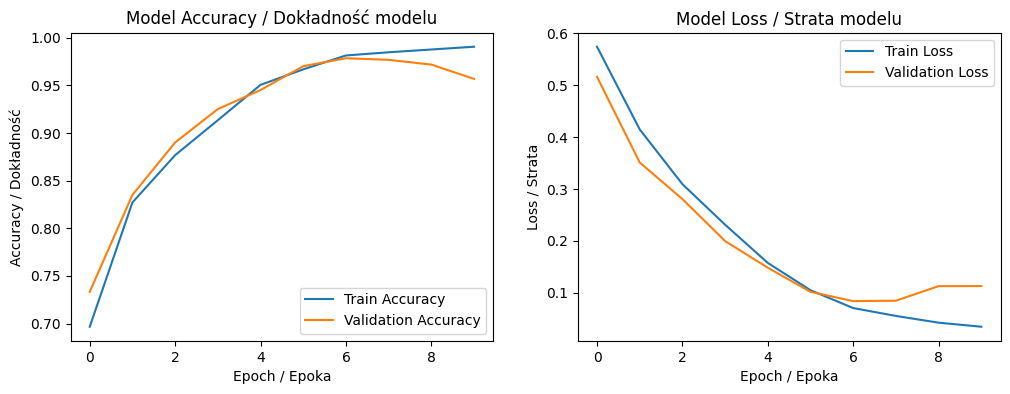

In [23]:
# Import matplotlib for plotting / Importuj matplotlib do tworzenia wykresów
import matplotlib.pyplot as plt

# Plot training & validation accuracy / Wykres dokładności dla zbioru treningowego i walidacyjnego
plt.figure(figsize=(12, 4))

# Accuracy plot / Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy / Dokładność modelu')
plt.xlabel('Epoch / Epoka')
plt.ylabel('Accuracy / Dokładność')
plt.legend()

# Plot training & validation loss / Wykres straty dla zbioru treningowego i walidacyjnego
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss / Strata modelu')
plt.xlabel('Epoch / Epoka')
plt.ylabel('Loss / Strata')
plt.legend()

plt.show()


From the accuracy chart (left) and the loss chart (right), we can see that:

1. High Accuracy, Low Loss
    - The model’s training accuracy quickly rises and stabilizes around 97–99%, while the validation accuracy follows closely at around 95–98%.
    - Both the training loss and validation loss decrease steadily, indicating that the model is learning effectively.

2. Minor Gap Between Training and Validation
    - The gap between the training accuracy (blue line) and validation accuracy (orange line) remains small, suggesting that overfitting is not a major issue.
    - Likewise, the loss curves for training and validation are relatively close, which also points to good generalization.

3. Slight Plateau Toward the End
    - The curves begin to level off after a few epochs, meaning the model has likely reached a near-optimal performance for the given architecture and dataset.

Overall, the results indicate that the CNN is performing well, achieving high accuracy on both the training and validation sets. If you wish to further improve the model, you could consider:
- Data augmentation to increase the effective size of the training set.
- Hyperparameter tuning (e.g., changing learning rate, batch size, number of epochs) to see if further gains are possible.
- More advanced architectures or transfer learning from a pretrained model.


Analizując wykres dokładności (po lewej) oraz wykres straty (po prawej), możemy zauważyć, że:

1. Wysoka dokładność, niska strata
    - Dokładność modelu na zbiorze treningowym szybko rośnie i stabilizuje się w okolicach 97–99%, a dokładność walidacyjna osiąga podobny poziom, około 95–98%.
    - Zarówno strata treningowa, jak i walidacyjna systematycznie maleją, co oznacza, że model uczy się skutecznie.

2. Niewielka różnica między treningiem a walidacją
    - Różnica między dokładnością treningową (niebieska linia) a walidacyjną (pomarańczowa linia) jest mała, co sugeruje, że przeuczenie (overfitting) nie stanowi poważnego problemu.
    - Podobnie krzywe strat dla zbioru treningowego i walidacyjnego są do siebie zbliżone, co świadczy o dobrej generalizacji modelu.

3. Niewielkie wypłaszczenie pod koniec
    - Wraz z kolejnymi epokami wykresy zaczynają się wypłaszczać, co oznacza, że model osiągnął prawdopodobnie bliski optymalny poziom dokładności przy tej architekturze i zestawie danych.

Podsumowując, wyniki wskazują na to, że sieć CNN działa bardzo dobrze, osiągając wysoką dokładność zarówno na zbiorze treningowym, jak i walidacyjnym. Aby dodatkowo ulepszyć model, można rozważyć:
- Augmentację danych (np. obrót, odbicie, skalowanie), aby zwiększyć różnorodność zbioru treningowego.
- Strojenie hiperparametrów (np. zmiana współczynnika uczenia, rozmiaru paczki, liczby epok) w celu dalszej poprawy wyników.
- Bardziej zaawansowane architektury lub wykorzystanie transfer learning z gotowych modeli.